Before we start, let's talk about the upcoming Midterm Exam.

<h2 align="center">Thursday, October 15</h2>

<h3 align="center">Check your email to find out the time you are scheduled to take the exam!</h3>


**<font color=blue>Material Allowed:</font>**
* You are allowed 1-page A4-sized front and back of formulas (handwritten or typed).
* Bring clean paper to write your answers (go ahead and get extra, just in case).
* Bring a second device (e.g., phone, tablet or other) with the [CamScanner](https://www.camscanner.com/) or [Scannable](https://evernote.com/products/scannable) app installed. This device is only to be used at the end of the exam to take pictures of your handwritten solutions.
* **<font color=orange>TOTAL TIME:</font>** 2 hours + 15 minutes

**<font color=red>Communications between students or anyone else is considered cheating. Turn off all Slack notifications and other communications channels!</font>**

Ten (10) minutes prior to the time you are scheduled to take the exam, you will be able to see the Midterm Exam quiz on Canvas.

Make sure your testing environment is comfortable, and start whenever you are ready.

The total allocated time for each part is 2 hours + 15 minutes, the "clock" starts counting when you begin to take the quiz.

**<font color=blue>Coverage \& Review:</font>**
* The midterm exam will cover Lectures 1-17
* A practice quiz has been created in Canvas so you can practice the Honorlock testing environment: [Practice Exam Quiz](https://ufl.instructure.com/courses/404363/quizzes/894726)
* Last year's midterm exam has been posted along with solutions: [Practice Exam + Solutions](https://github.com/Fundamentals-of-Machine-Learning-F20/Assignment-Solutions/tree/master/Previous%20Years%20Midterm)
* **<font color=orange>IN CLASS EXAM REVIEW:</font>** On Monday, October 12, we will use the usual time of the class to conduct a midterm review. **Post your questions in the [Midterm Review Discussion board](https://ufl.instructure.com/courses/404363/discussion_topics/2694276), to be answered and discussed during class time.** (If no questions are posted, new material will be covered.)

# Lecture 15 - Clustering; K-Means Algorithm

Let's quickly review GMM applications with some practical illustrations:

### GMM as Data Likelihood Estimation or Clustering

In [1]:
from scipy.stats import multivariate_normal
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

from IPython.display import Image

In [ ]:
def make_GaussianMixture(N, Means, Sigs, Pis):
    X = np.empty((0,Means.shape[1]))
    L = np.empty(0)
    for i in range(N):
        rv = npr.uniform()   # sample uniform RV
        GaussianChosen = np.where(rv < np.cumsum(Pis))[0][0]
        L = np.append(L, GaussianChosen)
        X = np.append(X, np.array([npr.multivariate_normal(Means[GaussianChosen], 
                                                           np.eye(Means.shape[1])*Sigs[GaussianChosen])]), axis=0)
    return X, L

In [ ]:
N = 10000
Means = np.array([[1,1],[0,0],[-.5, 1],[.5, 1.5]])
Sigs = [.1, .01, .05, .05]
Pis = [.4, .25, .25, .1]

X,L = make_GaussianMixture(N, Means, Sigs, Pis)

fig = plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(1,2,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');

In [ ]:
from sklearn.mixture import GaussianMixture

Nclusters = 5
GMM = GaussianMixture(n_components=Nclusters).fit(X)
labels = GMM.predict(X)
prob = GMM.predict_proba(X).round(2)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,Nclusters,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(2,Nclusters,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');
fig.add_subplot(2,Nclusters,3)
plt.scatter(X[:,0],X[:,1], c=labels)
plt.title('Predicted Labels');
for i in range(Nclusters):
    ax = fig.add_subplot(2,Nclusters,Nclusters+i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=prob[:,i])
    fig.colorbar(p1, ax=ax)

### GMM as Density Estimation

Consider some data generated from Scikit-Learn's ```make_moons``` function:

In [ ]:
from sklearn.datasets import make_moons
from matplotlib.patches import Ellipse

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Let's create a helper function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output. 

* Let's not worry about the implementation of this helper function.

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

In [ ]:
GMM = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

In [ ]:
GMM16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. 

For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

In [ ]:
Xnew = GMM16.sample(100)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

# Clustering

<div class="alert alert-success">
    <b>Clustering</b>
    
Clustering is a type of *unsupervised* Machine Learning technique. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.
</div>

Suppose you collect pictures of the following objects:

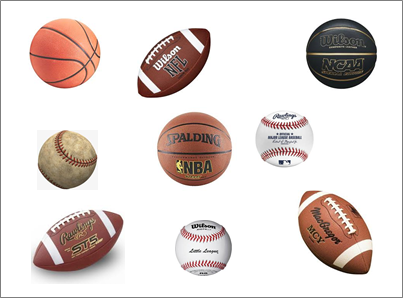

In [2]:
Image('figures/ClusteringExample.png', width=600)

* The goal in clustering is to partition the data into groups. 
    * How many groups would you partition this data into?

* We will first need to collect/extract features that characterize each object in each image.

* Then we can represent each image as a collection of features (in our polynomial regression problem, we use polynomial features, but we can use *any* basis function to characterize the data).

* In the feature space, we want to find partitions of the data. (In some cases we want to partition the original space - the input space of the images.)

* We have seen before that we can use *Gaussian Mixture Models* to characterize the data and then consider each Gaussian as distribution representation of each group.

Another popular clustering algorithm that takes a **non-parametric** form is called the **K-Means Algorithm**.

## K-Means Algorithm

K-Means algorithm is an iterative algorithm that tries to partition the dataset into $K$ pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to **only one group**. 

* It tries to make the *inter-cluster* data points as similar as possible while also keeping the clusters as different (far) as possible.

* It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster's centroid (arithmetic mean of all data points that belong to that cluster) is at the minimum.

* The less variation we have within clusters, the more homogenous (similar) the data points are within the same cluster.

The **pseudo-code** is summarized as follows:

1. Specify number of clusters $K$

2. Initialize centroids by first shuffling the dataset amd then randomly selecting $K$ data points for the centroids without replacement. (There are different ways of initializing the centroids)

3. Keep iterating until there is no change to the centroids, i.e., assignment of data points to clusters isn't changing.
    * Compute the sum of the squared distance between data points and all centroids
    * Assign each data pint to the closest cluster (centroid)
    * Compute the centroids for the clusters by taking the average of all data points that belong to each cluster
    

<div><img src="figures/KMeans.png", width="600"><!div>

The K-Means algorithm uses **Expectation-Maximization (EM) as the optimization approach**:
* The E-Step is assigning that data points to the closest cluster
* The M-step is computing the centroid of each cluster

As we learned before, optimization with EM is called **Alternating Optimization** and therefore the final solution will be **dependent** on the initialization (of cluster centroids). Therefore the final solution may not be the *optimal* (also referred to as *global*) solution.

* The objective function for the K-Means algorithm is:

\begin{align}
J(\Theta,U) &= \sum_{i=1}^N\sum_{k=1}^K u_{ik} d^2\left(x_i, \theta_k\right)\\
&= \sum_{i=1}^N\sum_{k=1}^K u_{ik} \Vert x_i - \theta_k\Vert_2^2\\
\text{ such that } & u_{ik}\in\{0,1\}\text{ and }\sum_{k=1}^K u_{ik} = 1
\end{align}

where $u_{ij}$ are cluster assignments, $\theta_j$ is the $j^{th}$ cluster representative and $d\left(x_i,\theta_k\right)$ is the distance between data point $x_i$ and cluster centroid $\theta_k$.

* In K-Means, we want to optimize:

$$\arg_{\Theta,U}\min J(\Theta,U)$$


* Does the K-means algorithm make any assumptions on cluster shape?
* Given a data set with an unknown number of clusters, can you come up with a strategy for determining the *right* number of clusters?
* Can we use other distance metrics in objective function $J(\Theta,U)$?

## Optimization of K-Means

In optimizing the cost function $J(\Theta,U)$, we want to find the best set of parameters $\{\Theta, U\}$ that minimize it.

**E-step**
\begin{align}
\frac{\partial J(\Theta,U)}{\partial u_{ik}} &= 0\\
\sum_{i=1} \Vert x_i - \theta_k\Vert_2^2 &= 0\\
\Rightarrow u_{ik} &= \begin{cases} 1 & \text{if } k=\arg\min_k \Vert x_i - \theta_k\Vert_2^2 \\ 0 & \text{otherwise}  \end{cases}
\end{align}

* In other words, assign the data point $x_i$ to the closest cluster judged by its sum of squared distance from the cluster's centroid.

**M-step**

\begin{align}
\frac{\partial J(\Theta,U)}{\partial \Theta} &= 0\\
-2 \sum_{i=1}^N u_{ik} \left(x_i-\theta_k\right) &= 0\\
\sum_{i=1}^N u_{ik}x_i = \sum_{i=1}^N u_{ik}\theta_k &=0 \\
\sum_{i=1}^N u_{ik}x_i = \theta_k\sum_{i=1}^N u_{ik} &=0 \\
\theta_k = \frac{\sum_{i=1}^N u_{ik}x_i}{\sum_{i=1}^N u_{ik}} \\
\theta_k = \frac{\sum_{i=1}^N u_{ik}x_i}{N_k} \\
\theta_k = \frac{\sum_{x_i\in C_k} x_i}{N_k} \\
\end{align}

where $N_k = \sum_{i=1}^N u_{ik}$ is the number of all data points assigned to cluster $C_k$, and $\sum_{x_i\in C_k} x_i=\sum_{i=1}^N u_{ik}x_i$ is the sum of data points that are assigned to cluster $C_k$.

* So the new cluster centroid is nothing but the **average** of all data points assigned to that cluster.

### Observations

* Since K-Means uses distance-based measurements to determine the *similarity* between data points, it's recommended to **scale the data** since almost always the features in any data set would have different units of measurements (e.g. age vs income).

* Given K-Means Alternating Optimization approach, different initializations may lead to different clusters, as K-Means algorithm may be stuck in a *local optima* and not converge to the *global optima*. Therefore, it's recommended to run the algorithm using different initializations of centroids and pick the results of the run that yielded the lower sum of squared distance.

* One of the convergence criteria is to check whether the assignment of data points has not changed from one iteration to the next. This criteria of "assignment of points not changing" is the same as observing no change in the *within-cluster variation*:
$$\frac{1}{N_k}\sum_{i\in c_k} \Vert x_i - \theta_k\Vert_2^2$$